In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Шаг 1: Загрузка данных и предварительная обработка
# Читаем CSV файл с данными и удаляем строки с пропущенными значениями.
data = pd.read_csv('data/salary.csv').dropna()

# Шаг 2: Создание целевой переменной
# Добавляем новую колонку 'HighIncome', которая принимает значение 1, если зарплата больше 100000, и 0, если меньше.
threshold = 100000
data['HighIncome'] = (data['Salary'] > threshold).astype(int)

# Шаг 3: Выделение признаков и целевой переменной
# X - это признаки, включающие возраст, пол, уровень образования, должность и опыт работы.
# y - это целевая переменная, которая указывает, имеет ли человек зарплату выше порога.
X = data[['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience']]
y = data['HighIncome']

# Шаг 4: Преобразование данных
# Разделяем признаки на числовые и категориальные. Числовые признаки стандартизируем, а категориальные закодируем с помощью OneHotEncoder.
categorical_features = ['Gender', 'Education Level', 'Job Title']
numeric_features = ['Age', 'Years of Experience']

# Используем ColumnTransformer для применения разных преобразований к числовым и категориальным признакам.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Преобразуем числовые данные с помощью стандартизации.
        ('cat', OneHotEncoder(), categorical_features)  # Преобразуем категориальные данные с помощью OneHotEncoder.
    ])

# Применяем преобразования к данным
X = preprocessor.fit_transform(X)

# Шаг 5: Разделение данных на тренировочные и тестовые наборы
# Разделяем данные на обучающую и тестовую выборки в соотношении 80/20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 6: Сохранение данных
# Сохраняем обработанные тренировочные и тестовые признаки в CSV файлы, а также метки (целевые переменные).
pd.DataFrame(X_train.toarray()).to_csv('train_features.csv', index=False)  # Преобразуем разреженную матрицу в плотный формат перед сохранением.
pd.DataFrame(X_test.toarray()).to_csv('test_features.csv', index=False)
pd.DataFrame(y_train).to_csv('train_labels.csv', index=False)
pd.DataFrame(y_test).to_csv('test_labels.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

class DecisionTree:
    # Шаг 1: Инициализация параметров дерева решений
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        # max_depth - максимальная глубина дерева
        # min_samples_split - минимальное количество примеров для разделения узла
        # min_samples_leaf - минимальное количество примеров в листьях
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None  # Изначально дерево пустое

    # Шаг 2: Обучение модели
    def fit(self, X, y):
        # Преобразуем данные в массивы numpy (если это pandas DataFrame или Series)
        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        # Строим дерево решений
        self.tree = self._build_tree(X, y)

    # Шаг 3: Прогнозирование
    def predict(self, X):
        # Проверяем, является ли вход X разреженной матрицей, если да, то преобразуем в плотный формат
        if not isinstance(X, np.ndarray):
            X = X.toarray()  # Преобразуем разреженную матрицу в плотную
        # Для каждого примера в данных, рекурсивно проходим по дереву и получаем прогноз
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    # Шаг 4: Расчет показателя Джини для узла
    def _gini(self, y):
        # Если y является pandas Series, преобразуем его в numpy массив
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        # Подсчитываем частоты меток и вычисляем индекс Джини
        counts = Counter(y)
        impurity = 1.0 - sum((count / len(y)) ** 2 for count in counts.values())
        return impurity

    # Шаг 5: Разделение данных по порогу
    def _split(self, X_column, threshold):
        # Если входные данные уже в формате numpy массива
        if isinstance(X_column, np.ndarray):
            left_indices = np.where(X_column <= threshold)[0]  # Индексы, где значения меньше или равны порогу
            right_indices = np.where(X_column > threshold)[0]  # Индексы, где значения больше порога
        else:
            # Если входные данные разреженная матрица, преобразуем в плотный формат
            X_column_dense = X_column.toarray().flatten()  # Преобразуем в плотный массив
            left_indices = np.where(X_column_dense <= threshold)[0]
            right_indices = np.where(X_column_dense > threshold)[0]
        return left_indices, right_indices

    # Шаг 6: Поиск наилучшего разбиения
    def _best_split(self, X, y):
        best_gini = float("inf")  # Изначально считаем наилучший индекс Джини бесконечно большим
        best_split = None
        for col in range(X.shape[1]):  # Для каждого признака в данных
            thresholds = np.unique(X[:, col])  # Находим все уникальные значения признака для возможных порогов
            for threshold in thresholds:
                # Разделяем данные по текущему порогу
                left_indices, right_indices = self._split(X[:, col], threshold)
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue  # Пропускаем, если одно из разбиений пусто
                # Вычисляем индекс Джини для левой и правой части
                gini_left = self._gini(y[left_indices])
                gini_right = self._gini(y[right_indices])
                gini = (len(left_indices) * gini_left + len(right_indices) * gini_right) / len(y)
                # Обновляем наилучшее разбиение, если текущий индекс Джини лучше
                if gini < best_gini:
                    best_gini = gini
                    best_split = (col, threshold)
        return best_split

    # Шаг 7: Рекурсивная постройка дерева решений
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape  # Количество образцов и признаков
        num_labels = len(np.unique(y))  # Количество уникальных меток

        # Остановка рекурсии: если достигнут максимум глубины или если количество уникальных меток 1
        if (self.max_depth and depth >= self.max_depth) or num_labels == 1 or num_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]  # Присваиваем значение наиболее частой метки
            return leaf_value

        # Находим наилучшее разбиение
        col, threshold = self._best_split(X, y)
        if col is None:
            leaf_value = Counter(y).most_common(1)[0][0]  # Если разбиение не найдено, присваиваем метку
            return leaf_value

        # Разделяем данные на левую и правую части
        left_indices, right_indices = self._split(X[:, col], threshold)

        # Разбиваем данные по рекурсии для левой и правой части
        left_y = y[left_indices]
        right_y = y[right_indices]

        # Рекурсивно строим поддеревья
        left_tree = self._build_tree(X[left_indices, :], left_y, depth + 1)
        right_tree = self._build_tree(X[right_indices, :], right_y, depth + 1)

        return {"col": col, "threshold": threshold, "left": left_tree, "right": right_tree}

    # Шаг 8: Прогнозирование для отдельного примера
    def _traverse_tree(self, x, tree):
        # Если входные данные разреженные, преобразуем в плотный массив
        if not isinstance(x, np.ndarray):
            x = x.toarray().flatten()

        # Если узел дерева является словарем, рекурсивно переходим по дереву
        if isinstance(tree, dict):
            if x[tree["col"]] <= tree["threshold"]:
                return self._traverse_tree(x, tree["left"])  # Идем в левое поддерево
            else:
                return self._traverse_tree(x, tree["right"])  # Идем в правое поддерево
        else:
            return tree  # Если достигнут лист дерева, возвращаем метку

In [ ]:
import numpy as np
from models.decision_tree import DecisionTree
from collections import Counter

class RandomForest:
    # Шаг 1: Инициализация модели случайного леса
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
        # n_estimators - количество деревьев в случайном лесу
        # max_depth - максимальная глубина деревьев
        # min_samples_split - минимальное количество образцов для разделения узла
        # min_samples_leaf - минимальное количество образцов в листьях
        # max_features - максимальное количество признаков для использования в каждом дереве (по умолчанию None, что означает использование всех признаков)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.trees = []  # Список для хранения построенных деревьев

    # Шаг 2: Обучение случайного леса
    def fit(self, X, y):
        self.trees = []  # Очищаем список деревьев перед обучением
        for _ in range(self.n_estimators):  # Для каждого дерева в лесу
            # Генерация случайных индексов для подвыборки с возвращением
            indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            # Создаем и обучаем дерево решений на подвыборке данных
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X[indices], y[indices])  # Обучаем дерево на случайной подвыборке
            self.trees.append(tree)  # Добавляем обученное дерево в список деревьев

    # Шаг 3: Прогнозирование с использованием случайного леса
    def predict(self, X):
        # Получаем прогнозы от всех деревьев в лесу
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # Для каждого примера данных находим наиболее часто встречающееся предсказание среди деревьев
        # Это называется голосованием большинства (majority voting)
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_predictions)

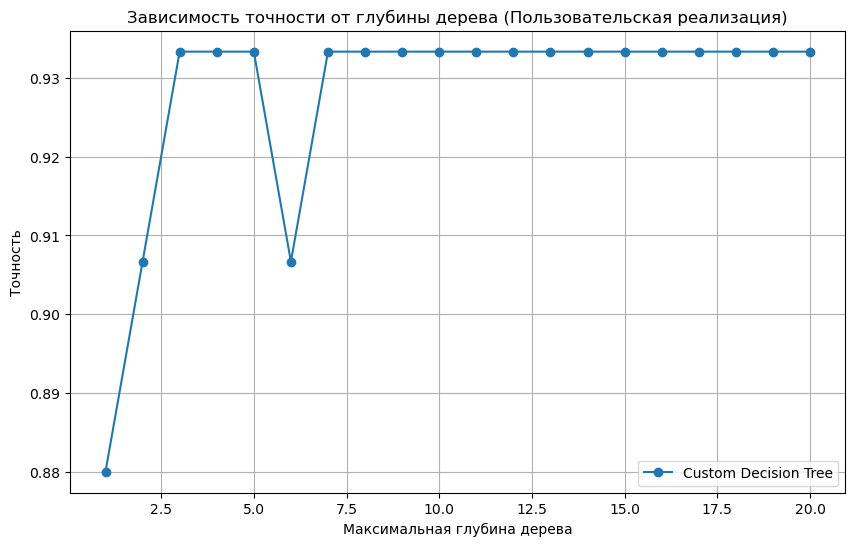

In [12]:
import matplotlib.pyplot as plt
from models.decision_tree import DecisionTree
import pandas as pd
import numpy as np

# Шаг 1: Загрузка данных
X_train = pd.read_csv('data/train_features.csv').values  # Загружаем тренировочные признаки
y_train = pd.read_csv('data/train_labels.csv').values.flatten()  # Загружаем тренировочные метки и преобразуем в одномерный массив
X_test = pd.read_csv('data/test_features.csv').values  # Загружаем тестовые признаки
y_test = pd.read_csv('data/test_labels.csv').values.flatten()  # Загружаем тестовые метки и преобразуем в одномерный массив

# Шаг 2: Перебор значений max_depth
depths = range(1, 21)  # Задаем диапазон значений для максимальной глубины дерева от 1 до 20
accuracies = []  # Список для хранения точности для каждой глубины

# Шаг 3: Обучение дерева и вычисление точности
for depth in depths:
    # Создаем экземпляр дерева решений с заданной максимальной глубиной
    tree = DecisionTree(max_depth=depth)
    tree.fit(X_train, y_train)  # Обучаем дерево на тренировочных данных
    predictions = tree.predict(X_test)  # Получаем предсказания на тестовых данных
    accuracy = np.mean(predictions == y_test)  # Рассчитываем точность (доля правильных предсказаний)
    accuracies.append(accuracy)  # Добавляем точность для текущей глубины дерева в список

# Шаг 4: Построение графика
plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
plt.plot(depths, accuracies, marker='o', label='Custom Decision Tree')  # Строим график зависимости точности от глубины дерева
plt.xlabel("Максимальная глубина дерева")  # Подпись оси X на русском
plt.ylabel("Точность")  # Подпись оси Y на русском
plt.title("Зависимость точности от глубины дерева (Пользовательская реализация)")  # Заголовок графика на русском
plt.legend()  # Показываем легенду
plt.grid()  # Включаем сетку на графике для удобства восприятия
plt.show()  # Отображаем график

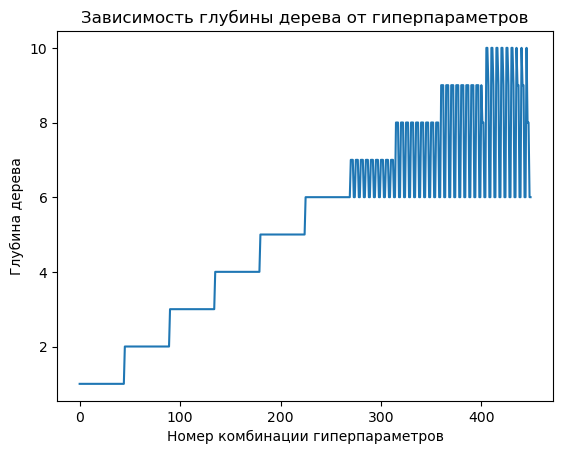

In [13]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

from models.data_preprocessing import X_train, y_train

# Шаг 1: Загрузка и подготовка данных
# В этом шаге предполагается, что данные были предварительно обработаны и разделены на признаки (X_train) и метки (y_train).
# Мы используем эти данные для обучения модели, однако код предобработки не показан.

# Шаг 2: Диапазоны для гиперпараметров
max_depths = range(1, 11)  # Определяем диапазон значений для максимальной глубины дерева от 1 до 10
min_samples_splits = range(2, 11)  # Определяем диапазон значений для минимального числа образцов для разделения от 2 до 10
min_samples_leafs = range(1, 6)  # Определяем диапазон значений для минимального числа образцов в листьях от 1 до 5

# Шаг 3: Список для хранения глубин деревьев
depths = []  # Список для сохранения глубины дерева для каждой комбинации гиперпараметров

# Шаг 4: Перебор гиперпараметров
# Мы перебираем все возможные комбинации гиперпараметров из заданных диапазонов
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leafs:
            # Создаем модель дерева решений с текущими значениями гиперпараметров
            clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            
            # Обучаем модель на тренировочных данных
            clf.fit(X_train, y_train)
            
            # Сохраняем максимальную глубину дерева после обучения
            depth = clf.tree_.max_depth
            depths.append(depth)  # Добавляем глубину для текущей комбинации гиперпараметров в список

# Шаг 5: Визуализация
# Строим график зависимости глубины дерева от номера комбинации гиперпараметров
plt.plot(depths)
plt.xlabel("Номер комбинации гиперпараметров")  # Подпись оси X на русском языке
plt.ylabel("Глубина дерева")  # Подпись оси Y на русском языке
plt.title("Зависимость глубины дерева от гиперпараметров")  # Заголовок графика на русском языке
plt.show()  # Отображаем график

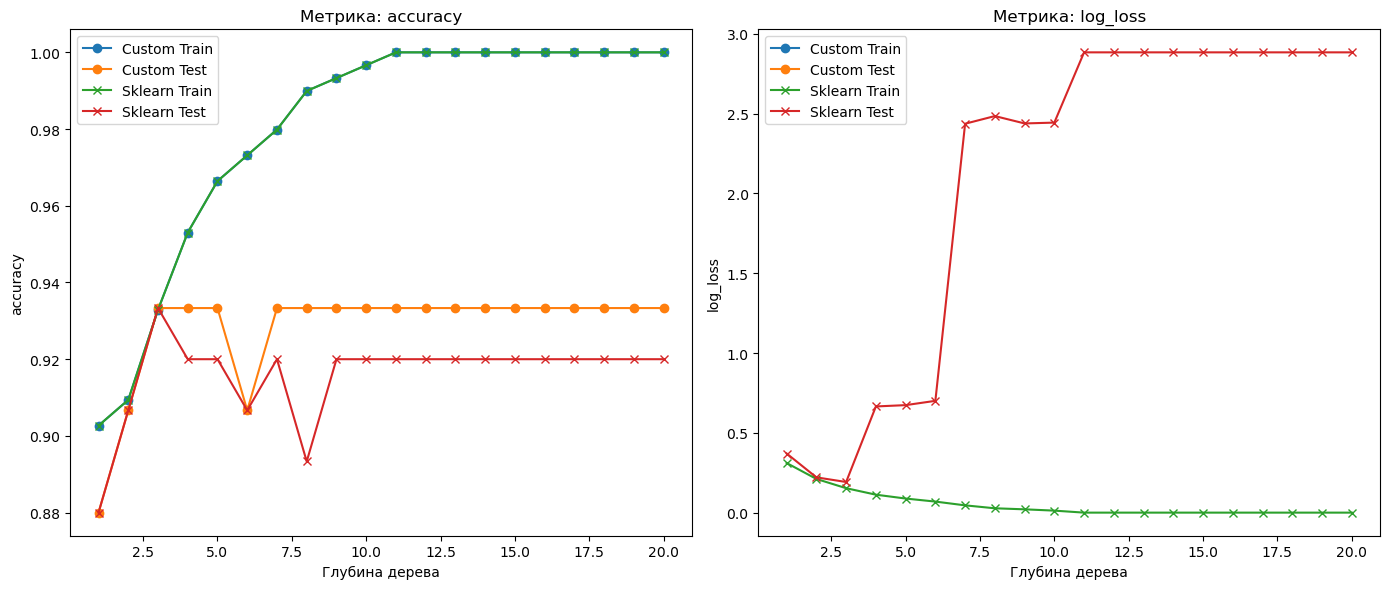

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from models.decision_tree import DecisionTree

# Шаг 1. Загрузка данных
# Загружаем тренировочные и тестовые данные, а также метки классов.
# X_train и X_test содержат признаки (features), а y_train и y_test — метки классов (labels).
X_train = pd.read_csv('data/train_features.csv').values
X_test = pd.read_csv('data/test_features.csv').values
y_train = pd.read_csv('data/train_labels.csv').values.ravel()
y_test = pd.read_csv('data/test_labels.csv').values.ravel()

# Шаг 2. Определение параметров
# Устанавливаем диапазон значений для гиперпараметра максимальной глубины дерева (max_depth).
# Также определяем метрики для оценки качества моделей: точность (accuracy) и log loss.
max_depth_values = range(1, 21)  # Глубина от 1 до 20
metrics = ['accuracy', 'log_loss']

# Словарь для хранения результатов для каждой модели и метрики.
results = {
    "custom_tree": {metric: {"train": [], "test": []} for metric in metrics},
    "sklearn_tree": {metric: {"train": [], "test": []} for metric in metrics}
}

# Шаг 3. Цикл по высотам деревьев
# Для каждой глубины дерева обучаем и оцениваем производительность как для вашей реализации, так и для библиотеки sklearn.
for max_depth in max_depth_values:
    custom_tree = DecisionTree(max_depth=max_depth)
    custom_tree.fit(X_train, y_train)  # Обучаем модель на тренировочных данных
    y_train_pred_custom = custom_tree.predict(X_train)  # Предсказания на тренировочных данных
    y_test_pred_custom = custom_tree.predict(X_test)  # Предсказания на тестовых данных

    # Библиотечная реализация дерева (sklearn)
    sklearn_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test
    sklearn_tree.fit(X_train_dense, y_train)  # Обучаем модель на тренировочных данных
    y_train_pred_sklearn = sklearn_tree.predict(X_train_dense)  # Предсказания на тренировочных данных
    y_test_pred_sklearn = sklearn_tree.predict(X_test_dense)  # Предсказания на тестовых данных
    y_train_proba_sklearn = sklearn_tree.predict_proba(X_train_dense)  # Вероятности на тренировочных данных
    y_test_proba_sklearn = sklearn_tree.predict_proba(X_test_dense)  # Вероятности на тестовых данных

    # Шаг 3.1. Оценка метрик
    # Вычисляем точность (accuracy) для обеих моделей и сохраняем результаты.
    results["custom_tree"]["accuracy"]["train"].append(accuracy_score(y_train, y_train_pred_custom))
    results["custom_tree"]["accuracy"]["test"].append(accuracy_score(y_test, y_test_pred_custom))
    results["sklearn_tree"]["accuracy"]["train"].append(accuracy_score(y_train, y_train_pred_sklearn))
    results["sklearn_tree"]["accuracy"]["test"].append(accuracy_score(y_test, y_test_pred_sklearn))

    results["sklearn_tree"]["log_loss"]["train"].append(log_loss(y_train, y_train_proba_sklearn))
    results["sklearn_tree"]["log_loss"]["test"].append(log_loss(y_test, y_test_proba_sklearn))
    results["custom_tree"]["log_loss"]["train"].append(None)
    results["custom_tree"]["log_loss"]["test"].append(None)

# Шаг 4. Визуализация результатов
# Строим графики для обеих метрик (точность и log loss) для каждой глубины дерева.
plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i + 1)
    # Строим графики для каждой модели (Custom и Sklearn) на тренировочных и тестовых данных
    plt.plot(max_depth_values, results["custom_tree"][metric]["train"], label='Custom Train', marker='o')
    plt.plot(max_depth_values, results["custom_tree"][metric]["test"], label='Custom Test', marker='o')
    plt.plot(max_depth_values, results["sklearn_tree"][metric]["train"], label='Sklearn Train', marker='x')
    plt.plot(max_depth_values, results["sklearn_tree"][metric]["test"], label='Sklearn Test', marker='x')
    # Устанавливаем подписи для графиков
    plt.title(f'Метрика: {metric}')  # Заголовок графика с метрикой на русском языке
    plt.xlabel('Глубина дерева')  # Подпись оси X на русском языке
    plt.ylabel(metric)  # Подпись оси Y с названием метрики
    plt.legend()  # Легенда графика

# Делаем размещение графиков удобным
plt.tight_layout()
# Отображаем графики
plt.show()

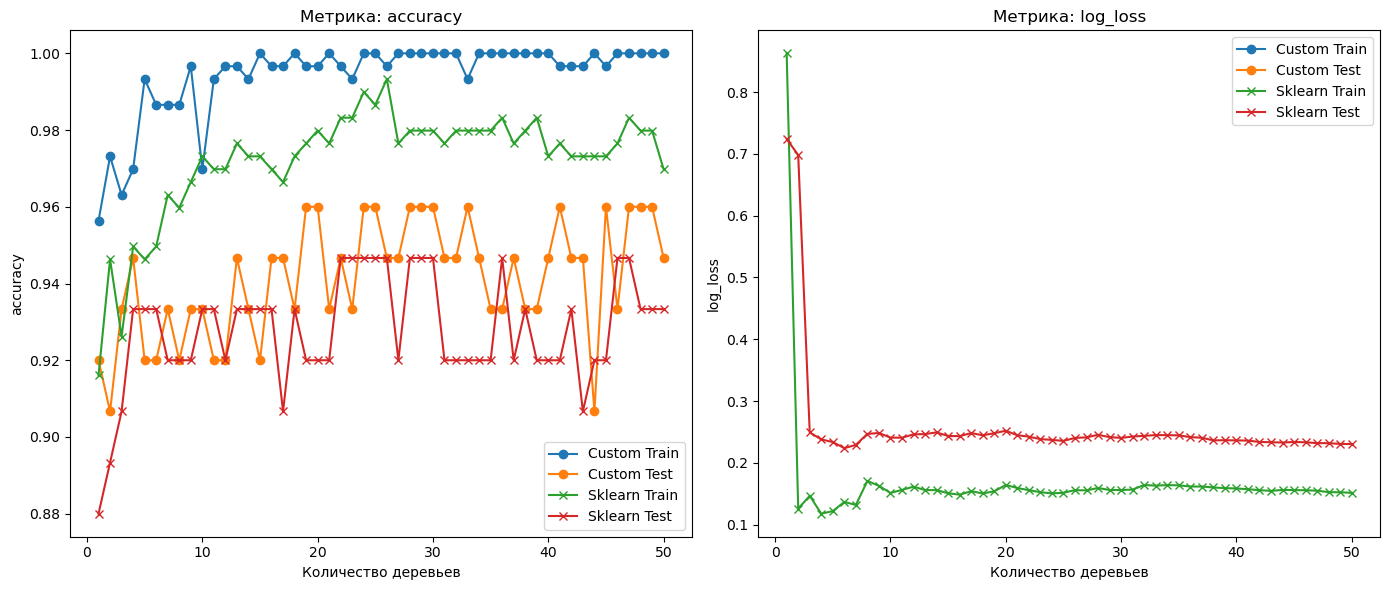

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from scipy.sparse import issparse
from models.random_forest import RandomForest

# Шаг 1. Загрузка данных
# Загружаем тренировочные и тестовые данные, включая признаки (X_train, X_test) и метки классов (y_train, y_test).
# Метод .ravel() используется для преобразования меток в одномерный массив.
X_train = pd.read_csv('data/train_features.csv').values
X_test = pd.read_csv('data/test_features.csv').values
y_train = pd.read_csv('data/train_labels.csv').values.ravel()
y_test = pd.read_csv('data/test_labels.csv').values.ravel()

# Шаг 2. Преобразование разреженных матриц (если нужно)
# Если данные представлены в виде разреженной матрицы (например, при использовании sparse форматов), 
# они преобразуются в плотный формат (dense).
if issparse(X_train):
    X_train = X_train.toarray()
if issparse(X_test):
    X_test = X_test.toarray()

# Шаг 3. Параметры для случайных лесов
# Устанавливаем диапазон значений для гиперпараметра количества деревьев (n_estimators).
# Для каждой модели будем отслеживать две метрики: точность (accuracy) и log loss.
n_trees_values = range(1, 51)  # Количество деревьев от 1 до 50
metrics = ['accuracy', 'log_loss']

# Словарь для хранения результатов для каждой модели и метрики.
results = {
    "custom_forest": {metric: {"train": [], "test": []} for metric in metrics},
    "sklearn_forest": {metric: {"train": [], "test": []} for metric in metrics}
}

# Шаг 4. Цикл по количеству деревьев
# Для каждого значения количества деревьев (n_estimators) обучаем и оцениваем модели.
for n_trees in n_trees_values:
    custom_forest = RandomForest(n_estimators=n_trees, max_depth=10)
    custom_forest.fit(X_train, y_train)  # Обучаем модель на тренировочных данных
    y_train_pred_custom = custom_forest.predict(X_train)  # Предсказания на тренировочных данных
    y_test_pred_custom = custom_forest.predict(X_test)  # Предсказания на тестовых данных

    # Библиотечная реализация случайного леса (sklearn)
    sklearn_forest = RandomForestClassifier(n_estimators=n_trees, max_depth=10, random_state=42)
    sklearn_forest.fit(X_train, y_train)  # Обучаем модель на тренировочных данных
    y_train_pred_sklearn = sklearn_forest.predict(X_train)  # Предсказания на тренировочных данных
    y_test_pred_sklearn = sklearn_forest.predict(X_test)  # Предсказания на тестовых данных
    y_train_proba_sklearn = sklearn_forest.predict_proba(X_train)  # Вероятности на тренировочных данных
    y_test_proba_sklearn = sklearn_forest.predict_proba(X_test)  # Вероятности на тестовых данных

    # Шаг 4.1. Оценка метрик
    # Вычисляем точность (accuracy) для обеих моделей и сохраняем результаты.
    results["custom_forest"]["accuracy"]["train"].append(accuracy_score(y_train, y_train_pred_custom))
    results["custom_forest"]["accuracy"]["test"].append(accuracy_score(y_test, y_test_pred_custom))
    results["sklearn_forest"]["accuracy"]["train"].append(accuracy_score(y_train, y_train_pred_sklearn))
    results["sklearn_forest"]["accuracy"]["test"].append(accuracy_score(y_test, y_test_pred_sklearn))

    # Для log loss вычисляем значение только для sklearn
    results["sklearn_forest"]["log_loss"]["train"].append(log_loss(y_train, y_train_proba_sklearn))
    results["sklearn_forest"]["log_loss"]["test"].append(log_loss(y_test, y_test_proba_sklearn))
    results["custom_forest"]["log_loss"]["train"].append(None)
    results["custom_forest"]["log_loss"]["test"].append(None)

# Шаг 5. Визуализация результатов
# Строим графики для метрик (точность и log loss) для различных значений количества деревьев.
plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i + 1)
    # Строим графики для каждой модели (Custom и Sklearn) на тренировочных и тестовых данных
    plt.plot(n_trees_values, results["custom_forest"][metric]["train"], label='Custom Train', marker='o')
    plt.plot(n_trees_values, results["custom_forest"][metric]["test"], label='Custom Test', marker='o')
    plt.plot(n_trees_values, results["sklearn_forest"][metric]["train"], label='Sklearn Train', marker='x')
    plt.plot(n_trees_values, results["sklearn_forest"][metric]["test"], label='Sklearn Test', marker='x')
    # Заголовок графика с метрикой на русском языке
    plt.title(f'Метрика: {metric}')
    # Подписи осей
    plt.xlabel('Количество деревьев')  # Подпись оси X на русском языке
    plt.ylabel(metric)  # Подпись оси Y с названием метрики
    plt.legend()  # Легенда графика

# Делаем размещение графиков удобным
plt.tight_layout()
# Отображаем графики
plt.show()

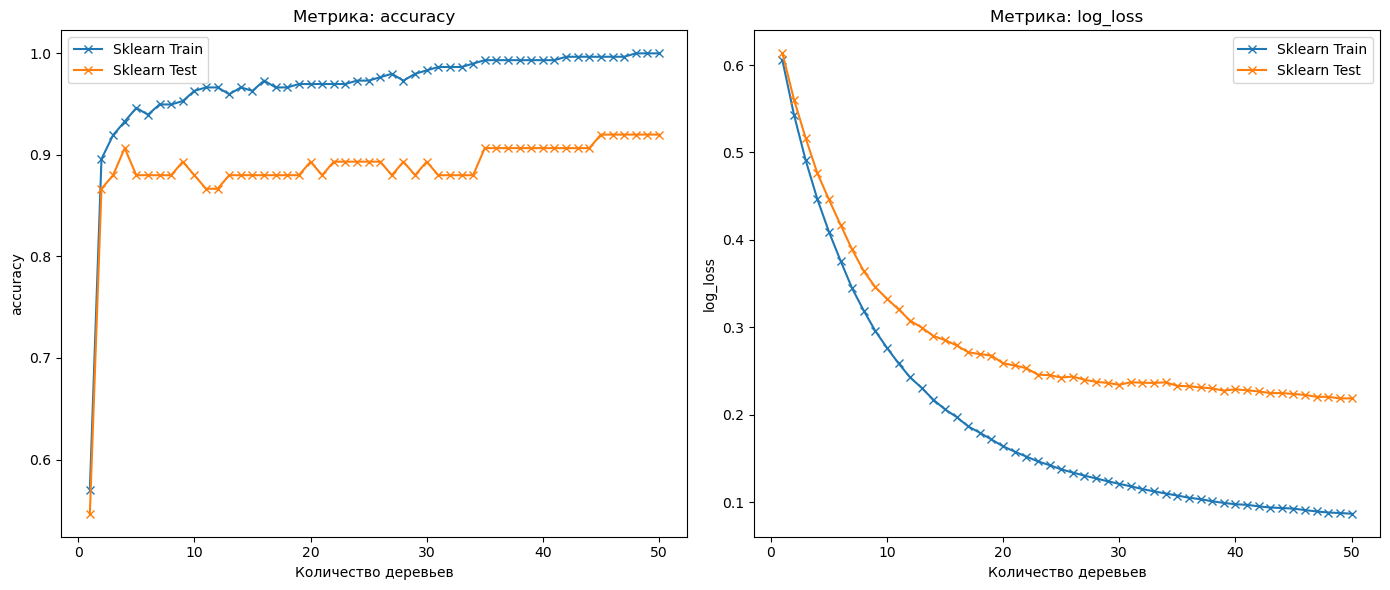

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss

# Шаг 1. Загрузка данных
# Загружаем тренировочные и тестовые данные, включая признаки (X_train, X_test) и метки классов (y_train, y_test).
# Метод .ravel() используется для преобразования меток в одномерный массив.
X_train = pd.read_csv('data/train_features.csv').values
X_test = pd.read_csv('data/test_features.csv').values
y_train = pd.read_csv('data/train_labels.csv').values.ravel()
y_test = pd.read_csv('data/test_labels.csv').values.ravel()

# Если данные разреженные, конвертируем их в плотный формат
# Проверяем, являются ли данные разреженными (sparse), и если да, то преобразуем их в плотный формат.
from scipy.sparse import issparse
if issparse(X_train):
    X_train = X_train.toarray()
if issparse(X_test):
    X_test = X_test.toarray()

# Шаг 2. Определение параметров
# Устанавливаем диапазон значений для гиперпараметра количества деревьев (n_estimators) от 1 до 50.
# Ожидаем, что будем отслеживать две метрики: точность (accuracy) и log loss.
n_trees_values = range(1, 51)  # Количество деревьев от 1 до 50
metrics = ['accuracy', 'log_loss']  # Метрики для оценки производительности

# Словарь для хранения результатов для каждой модели и метрики
results = {
    "sklearn_boosting": {metric: {"train": [], "test": []} for metric in metrics}
}

# Шаг 3. Цикл по количеству деревьев (n_estimators)
# Для каждого значения количества деревьев (n_estimators) обучаем модель градиентного бустинга
for n_trees in n_trees_values:
    # Библиотечная реализация градиентного бустинга
    sklearn_boosting = GradientBoostingClassifier(n_estimators=n_trees, max_depth=3, random_state=42)
    sklearn_boosting.fit(X_train, y_train)  # Обучаем модель на тренировочных данных
    y_train_pred_sklearn = sklearn_boosting.predict(X_train)  # Предсказания на тренировочных данных
    y_test_pred_sklearn = sklearn_boosting.predict(X_test)  # Предсказания на тестовых данных
    y_train_proba_sklearn = sklearn_boosting.predict_proba(X_train)  # Вероятности на тренировочных данных
    y_test_proba_sklearn = sklearn_boosting.predict_proba(X_test)  # Вероятности на тестовых данных

    # Оценка метрик
    # Точность (accuracy)
    results["sklearn_boosting"]["accuracy"]["train"].append(accuracy_score(y_train, y_train_pred_sklearn))
    results["sklearn_boosting"]["accuracy"]["test"].append(accuracy_score(y_test, y_test_pred_sklearn))

    # Log Loss
    results["sklearn_boosting"]["log_loss"]["train"].append(log_loss(y_train, y_train_proba_sklearn))
    results["sklearn_boosting"]["log_loss"]["test"].append(log_loss(y_test, y_test_proba_sklearn))

# Шаг 4. Визуализация результатов
# Строим графики для точности (accuracy) и log loss для различных значений количества деревьев (n_estimators)
plt.figure(figsize=(14, 6))

# Для каждой метрики строим подграфики: один для accuracy, другой для log_loss
for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i + 1)
    # Строим графики для метрики (train и test для sklearn)
    plt.plot(n_trees_values, results["sklearn_boosting"][metric]["train"], label='Sklearn Train', marker='x')
    plt.plot(n_trees_values, results["sklearn_boosting"][metric]["test"], label='Sklearn Test', marker='x')
    plt.title(f'Метрика: {metric}')
    plt.xlabel('Количество деревьев')
    plt.ylabel(metric)
    plt.legend()  # Легенда графика

# Автоматическая корректировка размещения подграфиков
plt.tight_layout()
# Отображаем все графики
plt.show()